In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import random
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(device)

cpu


Train size: 200, Holdout size: 80, Test size: 120


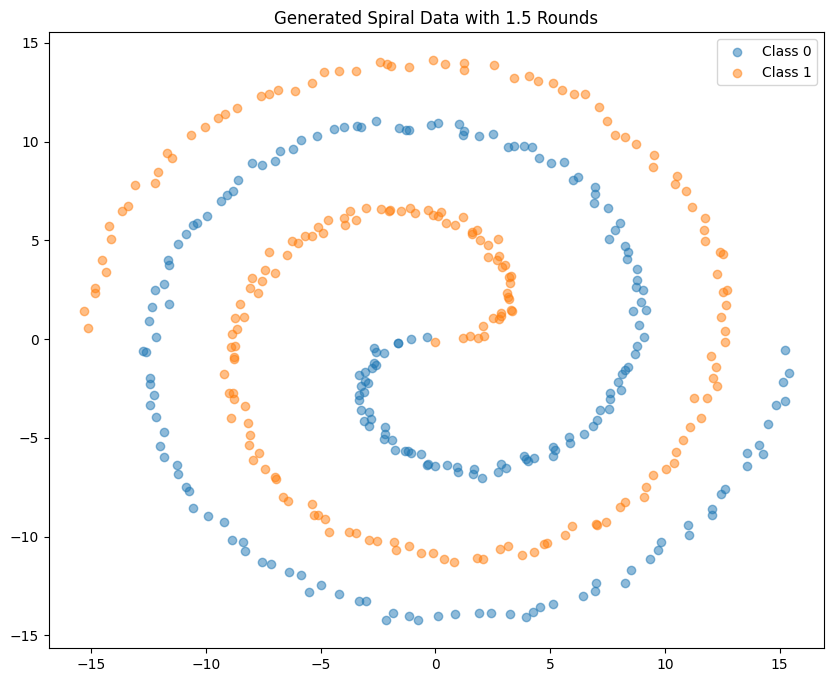

In [3]:
def generate_spiral_data(n_points = 1000, n_cycles = 5, noise_std_dev = 0.1):
    red_noise = np.random.normal(0, noise_std_dev, [2, n_points])
    blue_noise = np.random.normal(0, noise_std_dev, [2, n_points])

    # Generate Data
    theta_max = n_cycles * (2 * math.pi)
    step_size = theta_max / n_points

    red_data = [[5 * math.sqrt(t * step_size) * math.cos(t * step_size) + red_noise[0][t],
                 5 * math.sqrt(t * step_size) * math.sin(t * step_size) + red_noise[1][t]]
                for t in range(n_points)]

    blue_data = [[-5 * math.sqrt(t * step_size) * math.cos(t * step_size) + blue_noise[0][t],
                  -5 * math.sqrt(t * step_size) * math.sin(t * step_size) + blue_noise[1][t]]
                 for t in range(n_points)]

    data = np.array(red_data + blue_data)
    labels = np.array([1] * n_points + [0] * n_points)

    return list(zip(data, labels))

# Generate data
n_points = 200
n_cycles = 1.5
noise = 0.2
spiral_data = generate_spiral_data(n_points = n_points, n_cycles=n_cycles, noise_std_dev=noise)
random.shuffle(spiral_data)

# Split the data
train_ratio = 0.5
holdout_ratio = 0.2
test_ratio = 1- train_ratio - holdout_ratio

train_size = int(2*n_points * train_ratio)
holdout_size = int(2*n_points * holdout_ratio)
test_size = 2*n_points - train_size - holdout_size

print(f"Train size: {train_size}, Holdout size: {holdout_size}, Test size: {test_size}")

train_data = spiral_data[:train_size]
holdout_data = spiral_data[train_size:train_size + holdout_size]
swapped_holdout_data = [(data, 1 - label) for data, label in holdout_data]
test_data = spiral_data[train_size + holdout_size:train_size + holdout_size + test_size]

# Plot the generated spiral data
data, labels = zip(*spiral_data)
data = np.array(data)
labels = np.array(labels)

plt.figure(figsize=(10, 8))
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], label='Class 0', alpha=0.5)
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], label='Class 1', alpha=0.5)
plt.title(f'Generated Spiral Data with {n_cycles} Rounds')
plt.legend()
plt.show()

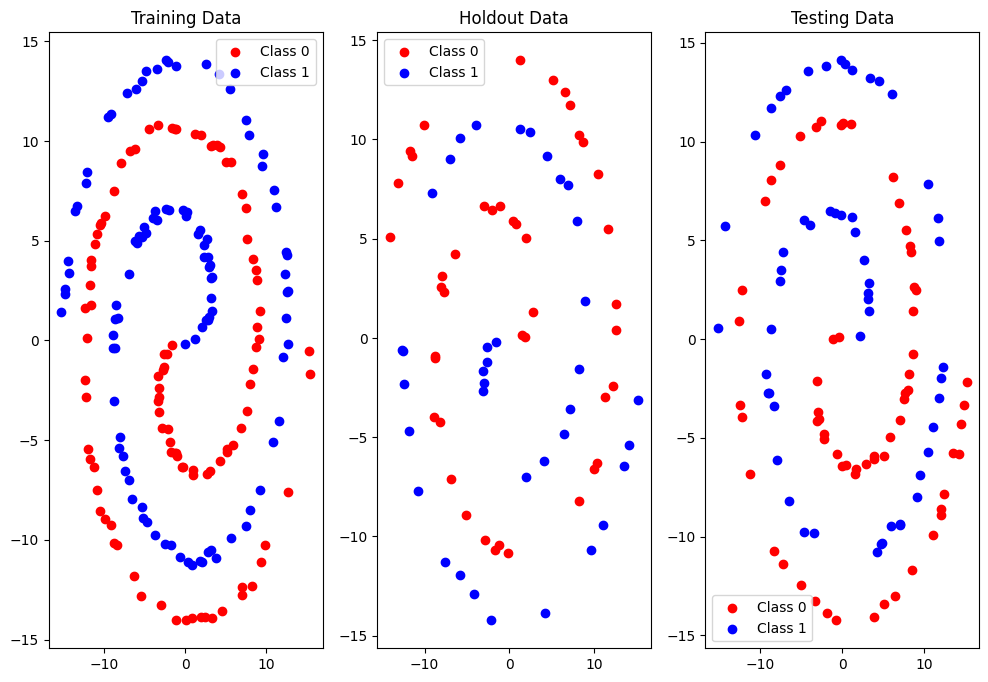

In [4]:
# Separate coordinates and labels for plotting
train_coords, train_labels = zip(*train_data)
holdout_coords, holdout_labels = zip(*swapped_holdout_data)
test_coords, test_labels = zip(*test_data)

train_coords = np.array(train_coords)
train_labels = np.array(train_labels)
holdout_coords = np.array(holdout_coords)
holdout_labels = np.array(holdout_labels)
test_coords = np.array(test_coords)
test_labels = np.array(test_labels)

# Plot the data
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.scatter(train_coords[train_labels == 0][:, 0], train_coords[train_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(train_coords[train_labels == 1][:, 0], train_coords[train_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Training Data')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(holdout_coords[holdout_labels == 0][:, 0], holdout_coords[holdout_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(holdout_coords[holdout_labels == 1][:, 0], holdout_coords[holdout_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Holdout Data')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(test_coords[test_labels == 0][:, 0], test_coords[test_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(test_coords[test_labels == 1][:, 0], test_coords[test_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Testing Data')
plt.legend()

plt.show()

In [5]:
class SpiralDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        coords, label = self.data[idx]
        return torch.tensor(coords).float(), torch.tensor(label).float().view(1)

In [6]:
untraining_data = train_data + swapped_holdout_data
random.shuffle(untraining_data)
untraining_coords, untraining_labels = zip(*untraining_data)
untraining_coords = np.array(untraining_coords)
untraining_labels = np.array(untraining_labels)

In [7]:
# Move data to device
train_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in train_data]
holdout_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in swapped_holdout_data]
test_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in test_data]
untraining_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in untraining_data]


In [8]:
train_dataset = SpiralDataset(train_data)
holdout_dataset = SpiralDataset(swapped_holdout_data)
test_dataset = SpiralDataset(test_data)
untraining_dataset = SpiralDataset(untraining_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
untraining_loader = DataLoader(untraining_dataset, batch_size=64, shuffle=True)

# Building a classifier

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 25)
        self.fc2 = nn.Linear(25, 25)
        self.fc3 = nn.Linear(25, 25)
        self.fc4 = nn.Linear(25, 25)
        self.fc5 = nn.Linear(25, 25)
        self.fc6 = nn.Linear(25, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [10]:
model = Net().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
param_history = []
param_history.append({name : params.clone() for name, params in model.state_dict().items()})

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        param_history.append({name: params.clone() for name, params in model.state_dict().items()})

    if epoch % 100 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

param_history.append({name: params.clone() for name, params in model.state_dict().items()})

# Testing Accuracy
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        labels.view(-1, 1)
        test_loss += criterion(outputs, labels).item()
        preds = outputs > 0
        correct += (preds == labels.byte()).float().sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss} Test Accuracy: {test_accuracy}')



/var/folders/8v/0ycxlxdx11zflk_8hpd0p8dw0000gn/T/ipykernel_41118/4254563249.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(coords).float(), torch.tensor(label).float().view(1)


Epoch 0 Loss: 0.740863025188446
Epoch 100 Loss: 0.4858158230781555
Epoch 200 Loss: 0.08304803818464279
Epoch 300 Loss: 0.00035623976145870984
Epoch 400 Loss: 0.00013600868987850845
Epoch 500 Loss: 0.04581861570477486
Epoch 600 Loss: 0.000927603105083108
Epoch 700 Loss: 1.3798150575894397e-05
Epoch 800 Loss: 9.662586535341688e-07
Epoch 900 Loss: 3.964738652939559e-07
Test Loss: 0.002409227801445013 Test Accuracy: 0.9916666666666667


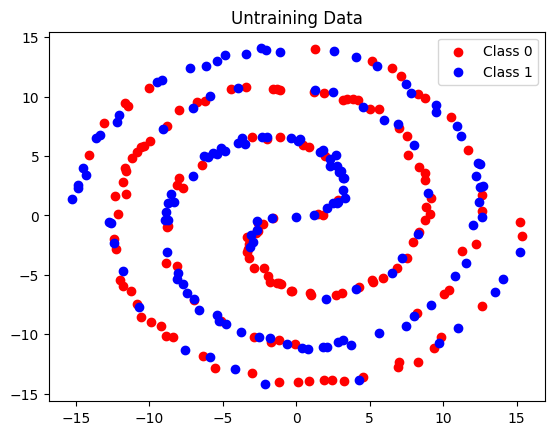

In [11]:
plt.Figure(figsize=(12, 8))
plt.scatter(untraining_coords[untraining_labels == 0][:, 0], untraining_coords[untraining_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(untraining_coords[untraining_labels == 1][:, 0], untraining_coords[untraining_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Untraining Data')
plt.legend()
plt.show()

In [12]:
def state_dict_to_vector(state_dict):
    return torch.cat([torch.flatten(params) for params in state_dict.values()])

In [13]:
def plot_decision_boundary(model, data, labels, title):
    model.eval()
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    grid = np.c_[xx.ravel(), yy.ravel()]
    inputs = torch.tensor(grid).float().to(device)
    outputs = model(inputs)
    preds = outputs > 0
    preds = preds.float()
    preds = preds.view(xx.shape)
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, preds.cpu(), alpha=0.8)
    plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], color='red', label='Class 0')
    plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], color='blue', label='Class 1')
    plt.title(title)
    plt.legend()
    plt.show()

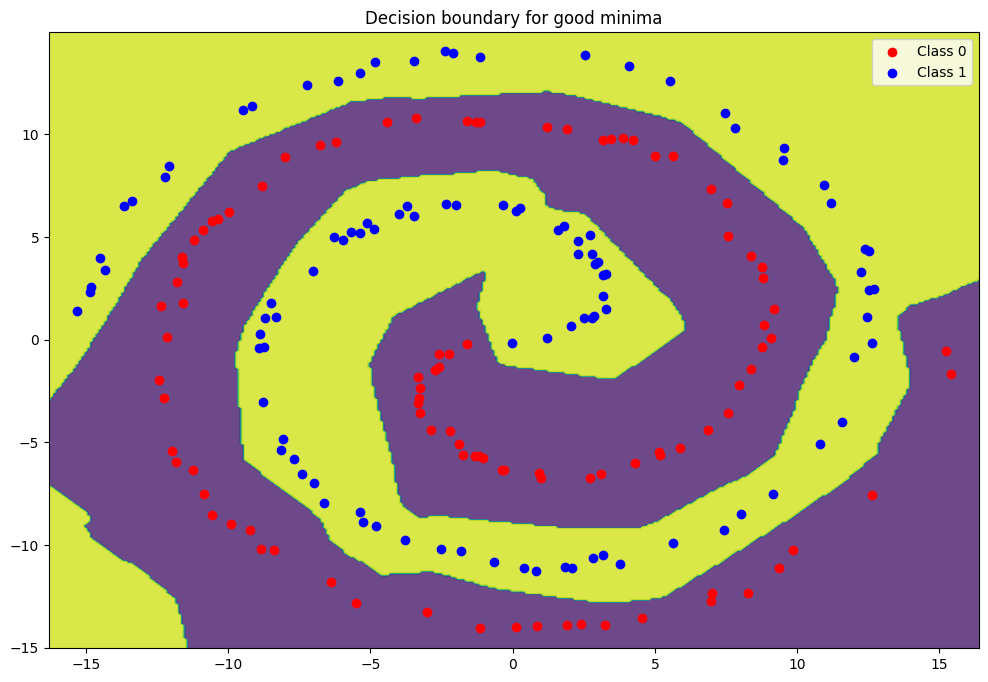

In [14]:
model.load_state_dict(param_history[-1])
plot_decision_boundary(model, train_coords, train_labels, 'Decision boundary for good minima')

# Checking the loss landscape of the model

In [15]:
def generate_random_directions(model):
    dir1_state_dict = {}
    dir2_state_dict = {}
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights = param.data
            dir1 = torch.randn_like(param)
            dir2 = torch.randn_like(param)
            dir1 = dir1 * torch.norm(weights) / torch.norm(dir1)
            dir2 = dir2 * torch.norm(weights) / torch.norm(dir2)
            dir1_state_dict[name] = dir1
            dir2_state_dict[name] = dir2
        else:
            dir1_state_dict[name] = torch.zeros_like(param)
            dir2_state_dict[name] = torch.zeros_like(param)
    
    return dir1_state_dict, dir2_state_dict


In [16]:
def compute_loss_surface(model, directions, alphas, betas, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, criterion):
    dir1_state_dict, dir2_state_dict = directions
    train_loss_surface = np.zeros((len(alphas), len(betas)))
    test_loss_surface = np.zeros((len(alphas), len(betas)))
    original_state_dict = {name: param.clone() for name, param in model.state_dict().items()}

    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            new_state_dict = {}
            for name, param in model.named_parameters():
                new_state_dict[name] = original_state_dict[name] + alpha * dir1_state_dict[name] + beta * dir2_state_dict[name]
            model.load_state_dict(new_state_dict)

            model.eval()
            with torch.no_grad():
                train_outputs = model(X_train_tensor).to(device)
                test_outputs = model(X_test_tensor).to(device)
                train_loss = criterion(train_outputs, y_train_tensor).to(device).item()
                test_loss = criterion(test_outputs, y_test_tensor).to(device).item()

            train_loss_surface[i, j] = train_loss
            test_loss_surface[i, j] = test_loss

    model.load_state_dict(original_state_dict)
    return train_loss_surface, test_loss_surface


In [17]:
def convert_params_into_vectors(params):
    vector = []
    for name, param in params.items():
        vector.append(param.view(-1))

    return torch.cat(vector)

In [18]:
def compute_trajectory(param_history, directions, final_params):
    trajectory = []
    dir1, dir2 = directions

    dir1_vector = convert_params_into_vectors(dir1)
    dir2_vector = convert_params_into_vectors(dir2)
    final_vector = convert_params_into_vectors(final_params)
    for params in param_history:
        vector = convert_params_into_vectors(params)
        alpha = torch.dot(vector - final_vector, dir1_vector) / torch.dot(dir1_vector, dir1_vector)
        beta = torch.dot(vector - final_vector, dir2_vector) / torch.dot(dir2_vector, dir2_vector)
        trajectory.append((alpha.item(), beta.item()))
    
    return trajectory

In [19]:
import plotly.graph_objects as go

def plot_loss_surface_3d(alpha_range, beta_range, loss_surface, trajectory, title, plot_trajectory=True):
    fig = go.Figure(data=[go.Surface(z=loss_surface, x=alpha_range, y=beta_range)])
    fig.update_layout(title=title, scene=dict(xaxis_title='Alpha', yaxis_title='Beta', zaxis_title='Loss'))
    alpha_points = trajectory[:, 0]
    beta_points = trajectory[:, 1]
    loss_points = [loss_surface[np.argmin(np.abs(alpha_range - alpha)), np.argmin(np.abs(beta_range - beta))] for alpha, beta in zip(alpha_points, beta_points)]
    if plot_trajectory:
        fig.add_trace(go.Scatter3d(x=alpha_points, y=beta_points, z=loss_points, mode='markers+lines', marker=dict(size=2, color='red')))
    
    fig.show()


In [20]:
model.load_state_dict(param_history[-1])
criterion = nn.BCEWithLogitsLoss()
X_train_tensor = torch.tensor(train_coords).float().to(device)
X_test_tensor = torch.tensor(test_coords).float().to(device)
y_train_tensor = torch.tensor(train_labels).float().view(-1, 1).to(device)
y_test_tensor = torch.tensor(test_labels).float().view(-1, 1).to(device)
final_params = param_history[-1]
directions = generate_random_directions(model)
alphas = np.linspace(-0.2, 0.2, 100)
betas = np.linspace(-0.2, 0.2, 100)
train_loss_surface_good, test_loss_surface_good = compute_loss_surface(model, directions, alphas, betas, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, criterion)
trajectory_good = compute_trajectory(param_history, directions, final_params)

In [21]:
plot_loss_surface_3d(alphas, betas, train_loss_surface_good, np.array(trajectory_good), 'Training Loss Surface at good minima')
plot_loss_surface_3d(alphas, betas, test_loss_surface_good, np.array(trajectory_good), 'Testing Loss Surface at good minima')

# Testing the model
 - 1000 training epochs - 10000 untraining epochs - 200 points - model

In [23]:
import os
import pickle

save_dir = 'train/params/spiral/'

# Load param_history and poison_points
with open(os.path.join(save_dir, 'param_history_cpu.pkl'), 'rb') as f:
    param_history = pickle.load(f)

with open(os.path.join(save_dir, 'poison_points_cpu.pkl'), 'rb') as f:
    poison_points = pickle.load(f)

param_history = [{name: params.cpu() for name, params in state_dict.items()} for state_dict in param_history]
poison_points = [{name: params.cpu() for name, params in state_dict.items()} for state_dict in poison_points]

In [24]:
import numpy as np
from sklearn.manifold import TSNE

# Assuming param_history and poison_points are already defined
def state_dict_to_vector(state_dict):
    return np.concatenate([param.numpy().flatten() for param in state_dict.values()])

param_history_vectors = [state_dict_to_vector(param) for param in param_history]
poison_points_vectors = [state_dict_to_vector(param) for param in poison_points]

combined_vectors = np.array(param_history_vectors + poison_points_vectors)

# Apply t-SNE
tsne = TSNE(n_components=2)
combined_tsne = tsne.fit_transform(combined_vectors)

# Split the transformed data back into param_history and poison_points
param_history_tsne = combined_tsne[:len(param_history_vectors)]
poison_points_tsne = combined_tsne[len(param_history_vectors):]

print(param_history_tsne.shape)
print(poison_points_tsne.shape)

(102, 2)
(102, 2)


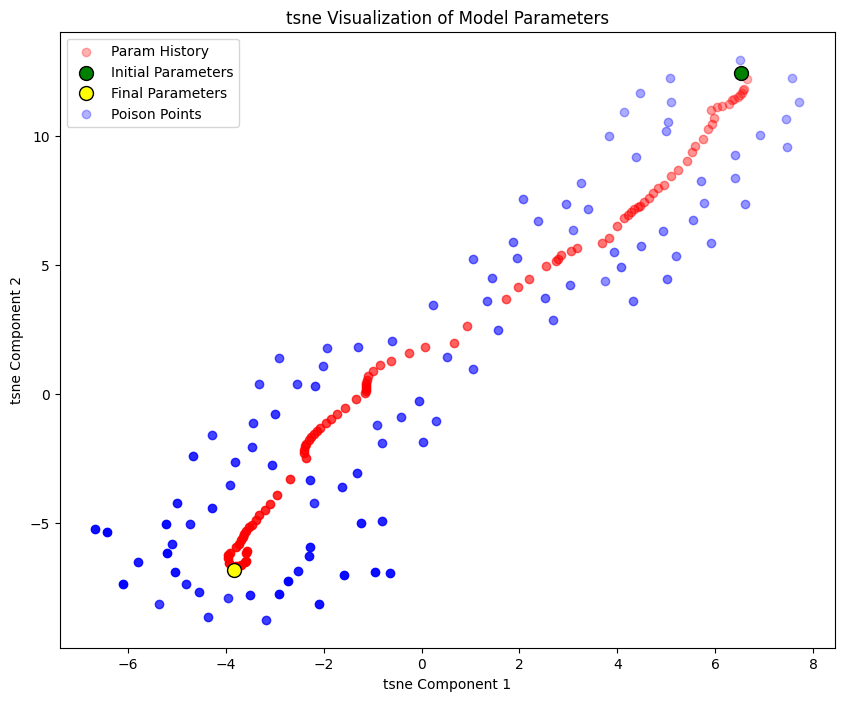

In [25]:
# Normalize the brightness
param_history_colors = np.linspace(0.3, 1, len(param_history_tsne))
poison_points_colors = np.linspace(0.3, 1, len(poison_points_tsne))

# Plot the points
plt.figure(figsize=(10, 8))

# Plot param_history points
for i, (x, y) in enumerate(param_history_tsne):
    plt.scatter(x, y, color=(1, 0, 0, param_history_colors[i]), label='Param History' if i == 0 else "")

plt.scatter(param_history_tsne[0, 0], param_history_tsne[0, 1], color='green', edgecolor='black', s=100, label='Initial Parameters')
plt.scatter(param_history_tsne[-1, 0], param_history_tsne[-1, 1], color='yellow', edgecolor='black', s=100, label='Final Parameters')

# Plot poison_points
for i, (x, y) in enumerate(poison_points_tsne):
    plt.scatter(x, y, color=(0, 0, 1, poison_points_colors[i]), label='Poison Points' if i == 0 else "")

# Add legend
plt.legend()
plt.title('tsne Visualization of Model Parameters')
plt.xlabel('tsne Component 1')
plt.ylabel('tsne Component 2')
plt.show()

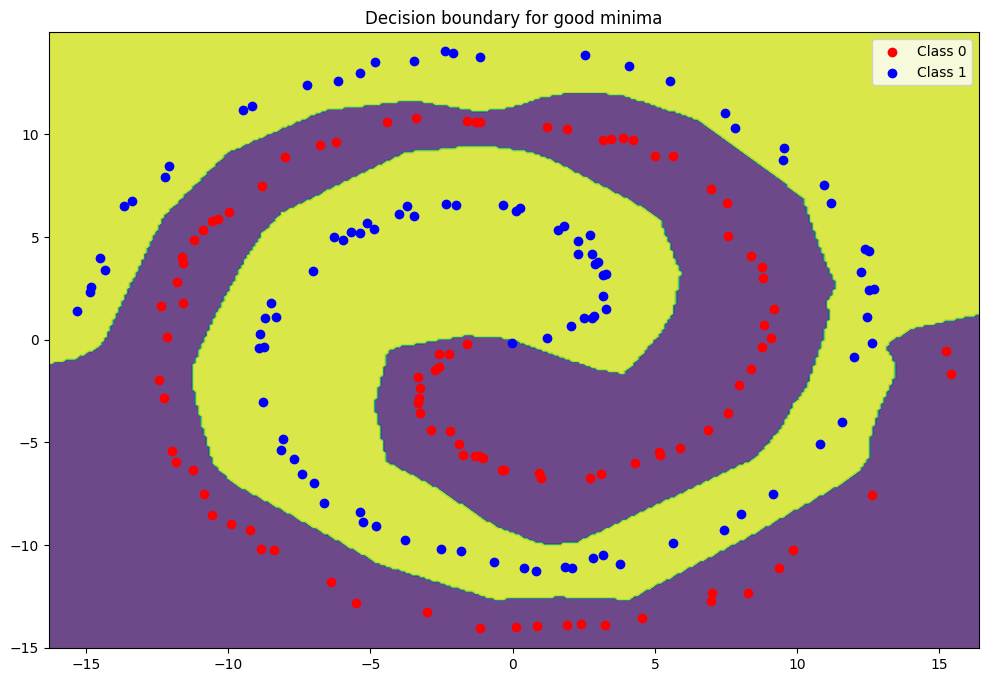

In [26]:
model = Net().to(device)
model.load_state_dict(param_history[-1])
plot_decision_boundary(model, train_coords, train_labels, 'Decision boundary for good minima')

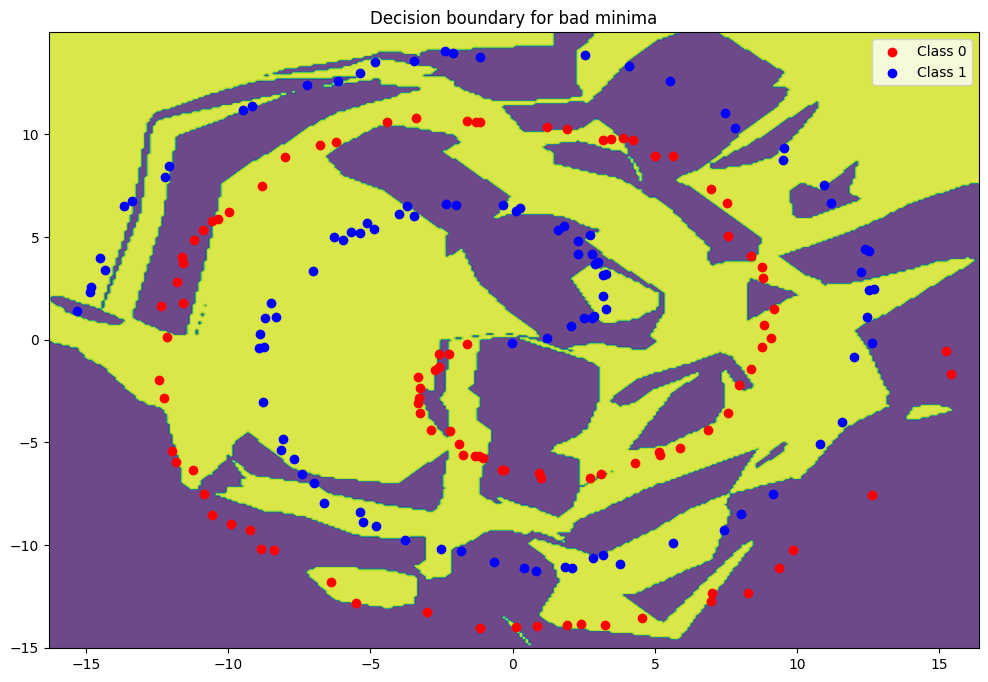

In [27]:
model.load_state_dict(poison_points[-1])
plot_decision_boundary(model, train_coords, train_labels, 'Decision boundary for bad minima')

In [28]:
model.load_state_dict(param_history[-1])
criterion = nn.BCEWithLogitsLoss()
X_train_tensor = torch.tensor(train_coords).float().to(device)
X_test_tensor = torch.tensor(test_coords).float().to(device)
y_train_tensor = torch.tensor(train_labels).float().view(-1, 1).to(device)
y_test_tensor = torch.tensor(test_labels).float().view(-1, 1).to(device)
final_params = param_history[-1]
directions = generate_random_directions(model)
alphas = np.linspace(-0.2, 0.2, 100)
betas = np.linspace(-0.2, 0.2, 100)
train_loss_surface_good, test_loss_surface_good = compute_loss_surface(model, directions, alphas, betas, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, criterion)
trajectory_good = compute_trajectory(param_history, directions, final_params)

In [29]:
plot_loss_surface_3d(alphas, betas, train_loss_surface_good, np.array(trajectory_good), 'Training Loss Surface at good minima')
plot_loss_surface_3d(alphas, betas, test_loss_surface_good, np.array(trajectory_good), 'Testing Loss Surface at good minima')

In [30]:
model.load_state_dict(poison_points[-1])
train_loss_surface_bad, test_loss_surface_bad = compute_loss_surface(model, directions, alphas, betas, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, criterion)

In [31]:
plot_loss_surface_3d(alphas, betas, train_loss_surface_bad, np.array(trajectory_good), 'Training Loss Surface at bad minima')
plot_loss_surface_3d(alphas, betas, test_loss_surface_bad, np.array(trajectory_good), 'Testing Loss Surface at bad minima')